<a href="https://colab.research.google.com/github/ebudd45/weather_data/blob/main/sounding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install siphon
!pip install metpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from metpy.units import units, pandas_dataframe_to_unit_arrays
from metpy.plots import SkewT, Hodograph, add_metpy_logo
import metpy.calc as mpcalc
from siphon.simplewebservice.wyoming import WyomingUpperAir
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
#set date and station
date = datetime(2019, 5, 20, 12)

station = input('Input station id:')
#station=input('Station id:')

df = WyomingUpperAir.request_data(date, station)

Input station id:oun


In [4]:
print('initial data')
df

initial data


,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,971.0,345,16.4,14.4,90.0,5.0,-5.000000,-3.061617e-16,OUN,72357,2019-05-20 12:00:00,35.18,-97.44,345.0,30.86
1,954.0,496,15.2,11.9,113.0,22.0,-20.251107,8.596085e+00,OUN,72357,2019-05-20 12:00:00,35.18,-97.44,345.0,30.86
2,941.4,610,17.7,11.1,130.0,35.0,-26.811556,2.249757e+01,OUN,72357,2019-05-20 12:00:00,35.18,-97.44,345.0,30.86
3,936.0,660,18.8,10.8,132.0,35.0,-26.010069,2.341957e+01,OUN,72357,2019-05-20 12:00:00,35.18,-97.44,345.0,30.86
4,930.0,715,20.0,14.0,133.0,35.0,-25.597380,2.386994e+01,OUN,72357,2019-05-20 12:00:00,35.18,-97.44,345.0,30.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,11.2,30480,-39.9,-80.5,65.0,15.0,-13.594617,-6.339274e+00,OUN,72357,2019-05-20 12:00:00,35.18,-97.44,345.0,30.86
107,10.7,30785,-39.8,-80.1,105.0,25.0,-24.148146,6.470476e+00,OUN,72357,2019-05-20 12:00:00,35.18,-97.44,345.0,30.86
108,10.2,31090,-39.6,-79.7,115.0,20.0,-18.126156,8.452365e+00,OUN,72357,2019-05-20 12:00:00,35.18,-97.44,345.0,30.86
109,10.0,31230,-39.5,-79.5,NaN,NaN,NaN,NaN,OUN,72357,2019-05-20 12:00:00,35.18,-97.44,345.0,30.86


In [5]:
#add in appropiate units

data = pandas_dataframe_to_unit_arrays(df)
#print(data_with_units)

subset_to_100 = data['pressure'] >= 150 * units.hPa

# Subset pressure and read in other data to only 100 mb
p = data['pressure']
height = data['height']
T = data['temperature']
Td = data['dewpoint']
u = data['u_wind']
v = data['v_wind']
deg = data['direction']
spd = data['speed']
#print(df.units)

In [6]:
#compute variables

#potential temp
pot = mpcalc.potential_temperature(p, T)

#relative humidity
rh = mpcalc.relative_humidity_from_dewpoint(T, Td)

#mixing ratio
mix = mpcalc.mixing_ratio_from_relative_humidity(p, T, rh)

#calculate path and levels from parcel

prof = (mpcalc.parcel_profile(p, T[0], Td[0])).to('degC')

#LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

#LFC
lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td, which='top')

#EL
el_pressure, el_temperature = mpcalc.el(p, T, Td, which='top')

#SBCAPE and SBCIN
cape, cin = mpcalc.cape_cin(p, T, Td, prof)

#mixed layer CAPE
ML_cape, ML_cin = mpcalc.mixed_layer_cape_cin(p,T,Td)


#MUCAP and MUCIN
MU_cape, MU_cin = mpcalc.most_unstable_cape_cin(p, T, Td)

#precipitable water 
pwat = mpcalc.precipitable_water(p, Td).to('inches')

#bulk shear
bulk_shear = mpcalc.bulk_shear(p, u, v, height=None, bottom=None, depth=None)

#bunkers storm motion
right_mover,left_mover,wind_mean = mpcalc.bunkers_storm_motion(p, u, v, height)

#helicity
pos_SRH,neg_SRH,total_SRH = mpcalc.storm_relative_helicity(height, v, v, 3000*units.meter, bottom=height[0], 
                                                           storm_u=right_mover[0], storm_v=right_mover[1])

/usr/local/lib/python3.9/dist-packages/metpy/calc/thermo.py:1194: UserWarning: Duplicate pressure(s) [16.0 50.0] hPa provided. Output profile includes duplicate temperatures as a result.
  warnings.warn(f'Duplicate pressure(s) {unique[counts > 1]:~P} provided. '


In [7]:
#calculate LI
def lifted_index(T,prof):
    '''this function calculates the lifted index.
    
       inputs:
       T = temperature
       prof = profile
       
       outputs: lifted_index'''
    
    tenv = T[np.where(p.m==500)]
    tpar = prof[np.where(p.m==500)]
    lifted_index = tenv-tpar
    return lifted_index[0]

li=lifted_index(T,prof).m

print(li)

3.9452785571707185


In [8]:
#calculate EHI
def energetic_helicity_index(cape,pos_SRH):
    '''this function calculates the EHI.
    
       inputs:
       cape = convective available potential energy
       pos_SRH = storm relative helicity
       
       outputs: energetic_helicity_index'''
    
    
    energetic_helicity_index = (cape*pos_SRH)/160000
    return energetic_helicity_index

EHI = energetic_helicity_index(cape,pos_SRH).m

print(EHI)

0.0


In [9]:
#calculate TT
def total_totals(T,Td):
    
    '''This is a function to calculate the total totals.
    
       inputs:
       T=temperature
       td=dew point
       
       outputs:
       total totals'''
    
    t850 = T[np.where(p.m ==850)]
    t500 = T[np.where(p.m ==500)]
    td850 = Td[np.where(p.m ==850)]
    vt = t850 -t500
    ct = td850 - t500
    
    total_totals = vt + ct
    return total_totals[0]

tt = total_totals(T,Td).m

print(tt)

53.8


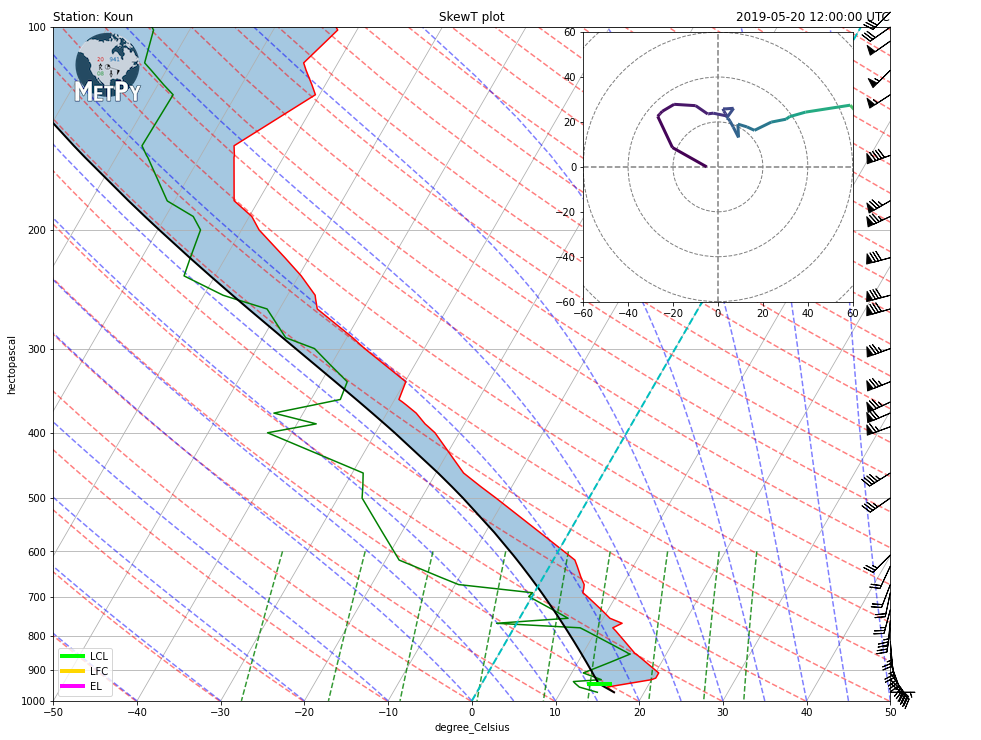

In [12]:
#plot sounding
fig = plt.figure(figsize=(15, 15))

skew = SkewT(fig)

skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')

# Plot barbs skipping to every other barb
skew.plot_barbs(p[::2], u[::2], v[::2], y_clip_radius=0.03)

# Set sensible axis limits
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-50, 50)

# Plot the skew-T parcel temperature profile
skew.plot(p, prof, 'k', linewidth=2)

# Plot a line marker at the LCL/LFC/EL level
skew.plot(lcl_pressure, lcl_temperature, 'k_', markersize=25, 
          markeredgewidth=4, color='lime', label='LCL')
skew.plot(lfc_pressure, lfc_temperature, 'k_', markersize=25, 
          markeredgewidth=4, color='gold', label='LFC')
skew.plot(el_pressure, el_temperature, 'k_', markersize=25, 
          markeredgewidth=4, color='magenta', label='EL')



# Add the relevant special lines
skew.plot_dry_adiabats(t0=np.arange(233,555,10)*units.K)
skew.plot_moist_adiabats(color='tab:green')
skew.plot_mixing_lines(color='tab:blue')
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof)
skew.shade_cape(p, T, prof)

# Plot titles
plt.title('Station: K{}'.format(station), loc='left')
plt.title('SkewT plot', loc='center')
plt.title('{} UTC'.format(date), loc='right')


plt.legend(loc='lower left')
add_metpy_logo(fig, 70, 635)

# Create a hodograph
data['height'] = data['height'] - data['height'][0]
boundaries = [0, 1, 3, 5, 8] * units.km
(_, u_trimmed, v_trimmed,
 speed_trimmed, height_trimmed) = mpcalc.get_layer(data['pressure'],
                                                   data['u_wind'],
                                                   data['v_wind'],
                                                   data['speed'],
                                                   data['height'],
                                                   height=data['height'],
                                                   depth=10 * units.km)
colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:olive']
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=60.)
h.add_grid(increment=20)
h.plot_colormapped(u_trimmed, v_trimmed, height_trimmed)

# Show the plot
plt.show()

In [11]:
#print out variables
print(f'Surface based CAPE: {cape}')
print(f'Surface based CIN: {cin}')
print()
print(f'MU based CAPE: {MU_cape}')
print(f'MU based CIN: {MU_cin}')
print()
print(f'ML based CAPE: {ML_cape}')
print(f'ML based CIN: {ML_cin}')
print()
print(f'Lifted Index: {li}')
print(f'Total Totals: {tt}')
print(f'Precipitable water: {pwat}')
print(f'0-3km SRH: {pos_SRH}')
print(f'EHI: {EHI}')
print()

if(((cape.m>=1500) and (li<=-2) and (cin.m>=-100) and (pos_SRH.m>=100) or (EHI>=1))):
   print('Severe weather possible')
else:
   print('Severe weather not likley')

Surface based CAPE: 0 joule / kilogram
Surface based CIN: 0 joule / kilogram

MU based CAPE: 1499.7753511113963 joule / kilogram
MU based CIN: -1.016083266644465 joule / kilogram

ML based CAPE: 0 joule / kilogram
ML based CIN: 0 joule / kilogram

Lifted Index: 3.9452785571707185
Total Totals: 53.8
Precipitable water: 1.2114588260504071 inch
0-3km SRH: 25.409912819698384 meter ** 2 / second ** 2
EHI: 0.0

Severe weather not likley
